# **STROJNO UČENJE - KLASIFIKACIJA SENTIMENTA TWEETOVA**

In [1]:
%pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [3]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [4]:
print("Dataset Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nSample data:\n", df)

Dataset Shape: (1600000, 6)

Missing values:
 target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

Sample data:
          target         ids                          date      flag  \
0             0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1             0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2             0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3             0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4             0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1599995       4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

 

In [5]:
# text cleaning
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    return text

df['clean_text'] = df['text'].apply(clean_text)

In [6]:
df.clean_text.head(10)

0       a thats a bummer  you shoulda got david car...
1    is upset that he cant update his facebook by t...
2     i dived many times for the ball managed to sa...
3      my whole body feels itchy and like its on fire 
4     no its not behaving at all im mad why am i he...
5                                  not the whole crew 
6                                          need a hug 
7     hey  long time no see yes rains a bit only a ...
8                             nope they didnt have it 
9                                       que me muera  
Name: clean_text, dtype: object

In [7]:
# sentiment mapping
df['sentiment'] = df['target'].apply(lambda x: 'positive' if x == 4 else 'negative')

df

,target,ids,date,flag,user,text,clean_text,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",a thats a bummer you shoulda got david car...,negative
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...,negative
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,negative
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,negative
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i he...,negative
...,...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,just woke up having no school is the best feel...,positive
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom very cool to hear old walt intervie...,positive
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me fo...,positive
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday to my boo of alll time tup...,positive



Number of tweets per sentiment:
 sentiment
negative    800000
positive    800000
Name: count, dtype: int64


C:\Users\beris\AppData\Local\Temp\ipykernel_22240\296647651.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='prism_r')


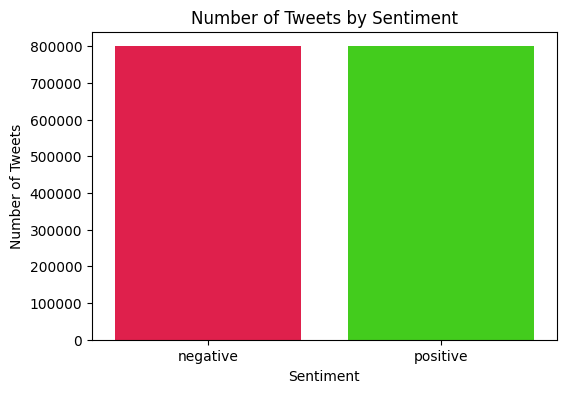

In [8]:
# sentiment counts
sentiment_counts = df['sentiment'].value_counts()
print("\nNumber of tweets per sentiment:\n", sentiment_counts)

# bar plot for sentiment distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='prism_r')
plt.title('Number of Tweets by Sentiment')
plt.ylabel('Number of Tweets')
plt.xlabel('Sentiment')
plt.show()

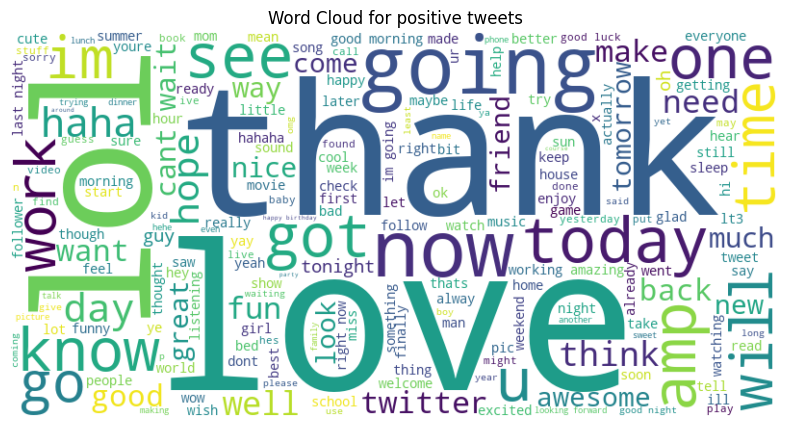

In [9]:
# WordCloud for positive tweets
positive_text = " ".join(df[df['sentiment'] == 'positive']['clean_text'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for positive tweets')
plt.show()

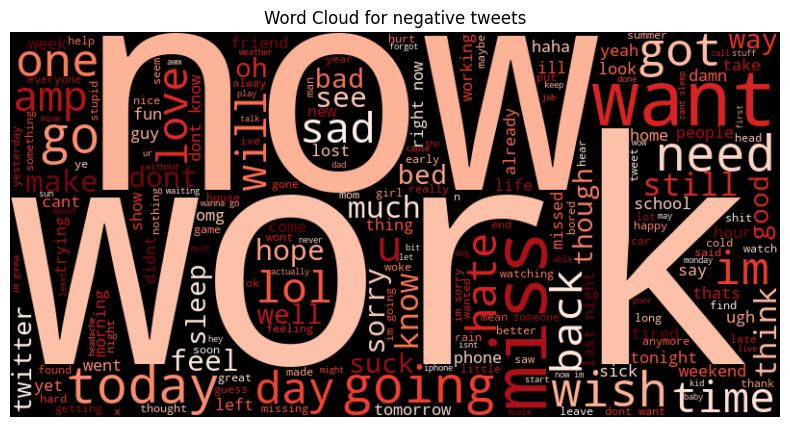

In [11]:
# WordCloud for negative tweets
negative_text = " ".join(df[df['sentiment'] == 'negative']['clean_text'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for negative tweets')
plt.show()

# **MACHINE LEARNING**

In [13]:
X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

featurizer = TfidfVectorizer()

X_train2 = featurizer.fit_transform(X_train)
X_test2  = featurizer.transform(X_test)

In [14]:
def get_test_scores(model_name:str,preds,y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy  = accuracy_score(y_test_data,preds)
    precision = precision_score(y_test_data,preds,average='macro')
    recall    = recall_score(y_test_data,preds,average='macro')
    f1        = f1_score(y_test_data,preds,average='macro')

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy]})

    return table

## Multinomial Naive Bayes model

In [15]:
MNB = MultinomialNB()
MNB.fit(X_train2, y_train)

MNB_train_preds   = MNB.predict(X_train2)
MNB_train_results = get_test_scores('MNB (train)', MNB_train_preds, y_train)

MNB_test_preds   = MNB.predict(X_test2)
MNB_test_results = get_test_scores('MNB (test)', MNB_test_preds, y_test)

MNB_results = pd.concat([MNB_train_results,MNB_test_results], axis=0)
MNB_results

,model,precision,recall,F1,accuracy
0,MNB (train),0.842009,0.839705,0.839474,0.839752
0,MNB (test),0.775310,0.772743,0.772110,0.772613


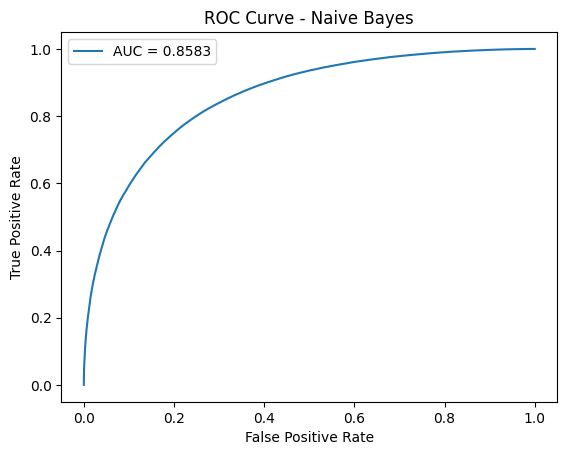

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_test_binary = y_test.replace({0: 0, 4: 1})

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_binary, MNB.predict_proba(X_test2)[:, 1])
auc = roc_auc_score(y_test_binary, MNB.predict_proba(X_test2)[:, 1])

plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend()
plt.show()

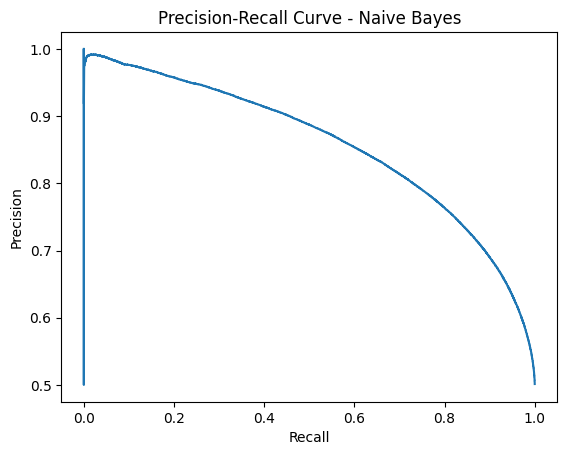

In [23]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test_binary, MNB.predict_proba(X_test2)[:, 1])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Naive Bayes')
plt.show()

In [21]:
from sklearn.metrics import classification_report

print("Classification Report - Naive Bayes:")
print(classification_report(y_test, MNB_test_preds, target_names=["Negative", "Positive"]))

Classification Report - Naive Bayes:
              precision    recall  f1-score   support

    Negative       0.75      0.82      0.78    239361
    Positive       0.80      0.72      0.76    240639

    accuracy                           0.77    480000
   macro avg       0.78      0.77      0.77    480000
weighted avg       0.78      0.77      0.77    480000



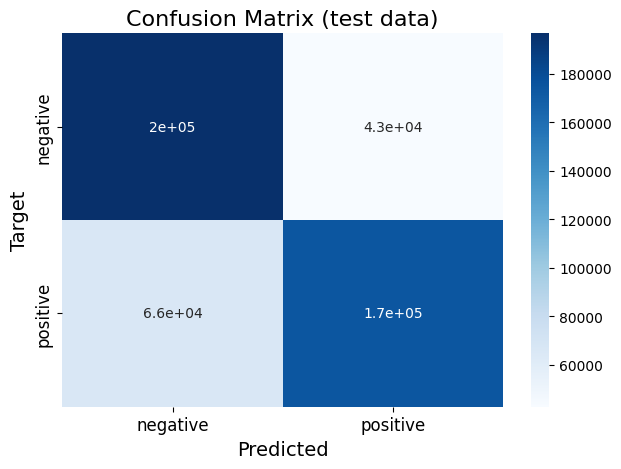

In [19]:
# confusion matrix for MNB results
cm = confusion_matrix(y_test, MNB_test_preds, labels=MNB.classes_)

ax = sns.heatmap(cm,annot=True, cmap='Blues')
ax.set_title('Confusion Matrix (test data)', fontsize=16)
ax.xaxis.set_ticklabels(['negative','positive'], fontsize=12)
ax.yaxis.set_ticklabels(['negative','positive'], fontsize=12)
ax.set_xlabel("Predicted", fontsize=14)
ax.set_ylabel("Target", fontsize=14)

plt.tight_layout()

## Model logističke regresije

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
# === LOGISTIČKA REGRESIJA ===

# Koristimo isti TF-IDF kao za MNB
# (featurizer već definiran i fit-an na X_train)

# Trenutni TF-IDF vektori:
# X_train2 - trenirajuci skup
# X_test2 - testni skup

# Treniranje modela
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train2, y_train)

# Predikcije i evaluacija
logreg_train_preds = logreg.predict(X_train2)
logreg_test_preds  = logreg.predict(X_test2)

logreg_train_results = get_test_scores('Logistic Regression (train)', logreg_train_preds, y_train)
logreg_test_results  = get_test_scores('Logistic Regression (test)', logreg_test_preds, y_test)

# Spajanje rezultata
logreg_results = pd.concat([logreg_train_results, logreg_test_results], axis=0)



REZULTATI LOGISTIČKE REGRESIJE

                         model  precision    recall        F1  accuracy
0  Logistic Regression (train)   0.824950  0.824737  0.824696  0.824722
0   Logistic Regression (test)   0.801859  0.801731  0.801729  0.801756





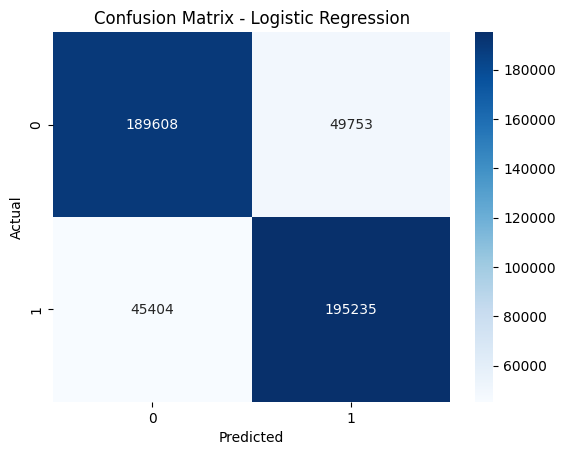

In [26]:
# Prikaz
print("\nREZULTATI LOGISTIČKE REGRESIJE\n")
print(logreg_results)
print("\n\n")

# Konfuzijska matrica
conf_matrix = confusion_matrix(y_test, logreg_test_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

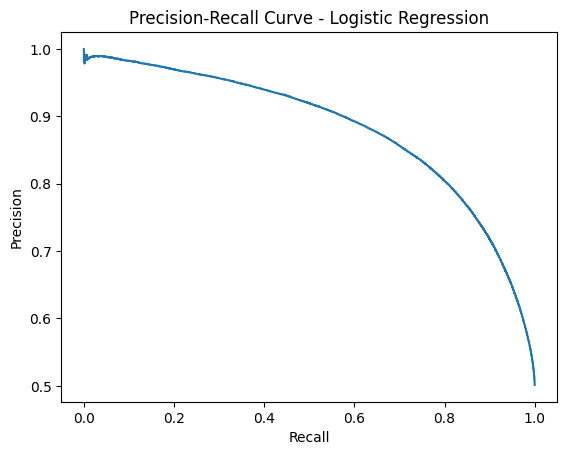

In [28]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test_binary, logreg.predict_proba(X_test2)[:, 1])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.show()

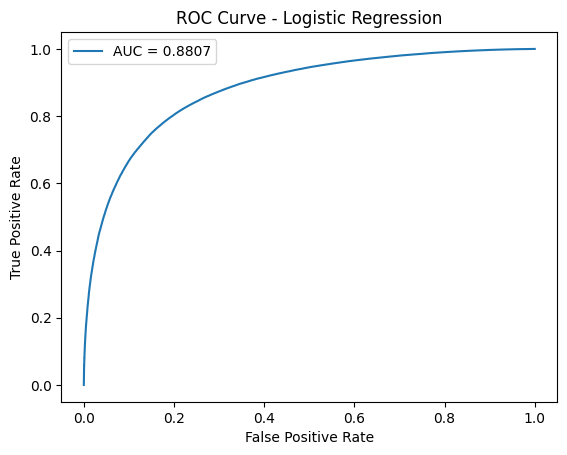

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test_binary, logreg.predict_proba(X_test2)[:, 1])
auc = roc_auc_score(y_test, logreg.predict_proba(X_test2)[:, 1])

plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

# LSTM model

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import os

# 🔹 1. Učitaj podatke
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin-1", header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = df[['text', 'target']]
df['target'] = df['target'].replace(4, 1)

In [33]:
# 🔹 2. Sample podataka
df = df.sample(n=300000, random_state=42).reset_index(drop=True)

# 🔹 3. Train/test split
X = df['text'].values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 4. Tokenizacija i padding
vocab_size = 30000
max_len = 60
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# 🔹 5. Učitaj GloVe vektore (osiguraj da je datoteka skinuta)
embedding_dim = 300
embedding_index = {}

glove_path = "glove.6B.300d.txt"  # osiguraj da se datoteka nalazi u istom folderu

with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

# 🔹 6. Kreiraj embedding matricu
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Epoch 1/12


C:\Users\beris\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 69s 46ms/step - accuracy: 0.6312 - loss: 0.6127 - val_accuracy: 0.7810 - val_loss: 0.4675
Epoch 2/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 69s 46ms/step - accuracy: 0.7919 - loss: 0.4545 - val_accuracy: 0.7906 - val_loss: 0.4481
Epoch 3/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 69s 46ms/step - accuracy: 0.8102 - loss: 0.4238 - val_accuracy: 0.7995 - val_loss: 0.4367
Epoch 4/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 69s 46ms/step - accuracy: 0.8187 - loss: 0.4045 - val_accuracy: 0.8018 - val_loss: 0.4322
Epoch 5/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 69s 46ms/step - accuracy: 0.8262 - loss: 0.3890 - val_accuracy: 0.8020 - val_loss: 0.4375
Epoch 6/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 71s 47ms/step - accuracy: 0.8358 - loss: 0.3695 - val_accuracy: 0.7799 - val_loss: 0.4749
Epoch 7/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 73s 48ms/step - accuracy: 0.8434 - loss: 0.3576 - val_accuracy: 0.8002 - val_loss: 0.4572
Epoch 8/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.8478 - loss: 0.34

✅ Accuracy:  0.7891
✅ Precision: 0.7827
✅ Recall:    0.7977
✅ F1 Score:  0.7901
✅ Model saved successfully!
✅ Tokenizer saved!


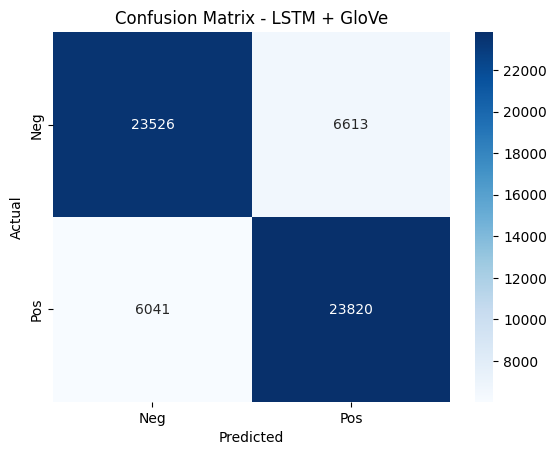

In [ ]:
# 🔹 7. Kreiraj model s GloVe embeddinzima
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len,
              weights=[embedding_matrix],
              trainable=True),  # Freezamo GloVe vektore
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 🔹 8. Treniraj model
history_lstm = model.fit(
    X_train_pad, y_train,
    epochs=12,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

# 🔹 9. Evaluacija
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

# 🔹 10. Spremanje modela i tokenizatora
model.save("sentiment_lstm_glove_model.h5")
print("✅ Model saved successfully!")

with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("✅ Tokenizer saved!")

# 🔹 11. Konfuzijska matrica
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LSTM + GloVe")
plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


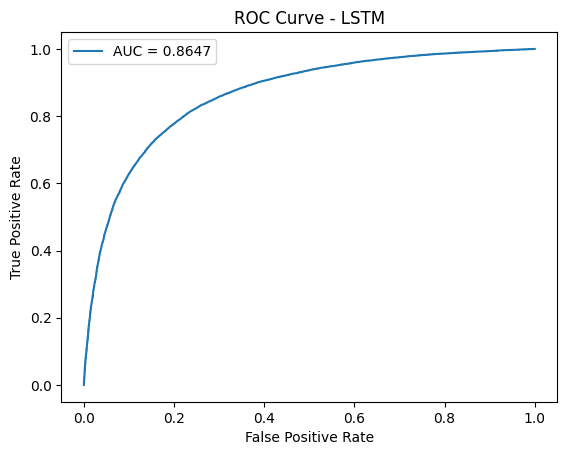

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Convert true labels to binary format if not already done
y_test_binary = y_test  # Assuming y_test is already binary (0 for negative, 1 for positive)

# Generate predictions probabilities from the LSTM model
y_pred_probs = model.predict(X_test_pad)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_probs)
auc = roc_auc_score(y_test_binary, y_pred_probs)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend()
plt.show()

# RNN model

In [38]:
from tensorflow.keras.layers import SimpleRNN

In [39]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    SimpleRNN(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 🔹 7. Treniranje
history_rnn = model.fit(X_train_pad, y_train,
                    epochs=12,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6482 - loss: 0.6157 - val_accuracy: 0.7724 - val_loss: 0.4847
Epoch 2/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7966 - loss: 0.4585 - val_accuracy: 0.7814 - val_loss: 0.4723
Epoch 3/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8201 - loss: 0.4138 - val_accuracy: 0.7881 - val_loss: 0.4544
Epoch 4/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8342 - loss: 0.3843 - val_accuracy: 0.7831 - val_loss: 0.4815
Epoch 5/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8490 - loss: 0.3570 - val_accuracy: 0.7820 - val_loss: 0.4769
Epoch 6/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8615 - loss: 0.3313 - val_accuracy: 0.7740 - val_loss: 0.4967
Epoch 7/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8724 - loss: 0.3098 - val_accuracy: 0.7749 - val_loss: 0.5202
Epoch 8/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8817 - loss: 0

In [40]:
# 🔹 8. Predikcija
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# 🔹 9. Evaluacija
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
✅ Accuracy:  0.7618
✅ Precision: 0.7602
✅ Recall:    0.7615
✅ F1 Score:  0.7608


In [41]:
# 🔹 11. Report
print("\n📄 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# 🔹 12. Pogrešne klasifikacije
test_df = pd.DataFrame({"text": X_test, "true_label": y_test, "predicted_label": y_pred, "predicted_prob": y_pred_probs.flatten()})
misclassified = test_df[test_df["true_label"] != test_df["predicted_label"]]

print("❌ Misclassified Examples:")
print(misclassified[['text', 'true_label', 'predicted_label', 'predicted_prob']].head(10))

print("🔴 False Positives:")
print(misclassified[misclassified['true_label'] == 0][['text', 'predicted_prob']].head(5))

print("🔵 False Negatives:")
print(misclassified[misclassified['true_label'] == 1][['text', 'predicted_prob']].head(5))


📄 Classification Report:

              precision    recall  f1-score   support

    Negative       0.76      0.76      0.76     30139
    Positive       0.76      0.76      0.76     29861

    accuracy                           0.76     60000
   macro avg       0.76      0.76      0.76     60000
weighted avg       0.76      0.76      0.76     60000

❌ Misclassified Examples:
                                                 text  true_label  \
7                      in beauty therapy! too hot  xx           0   
9   @mayank i use tweetdeck at my pc but while on ...           0   
14  T, work, eat, work, sleep, do it again. Living...           1   
16  I'm not having any of trouble I was having wit...           1   
21  8 girls 5 guys at my house right now. Not hati...           1   
27  I really want to see the UP movie...  when wil...           1   
28  @TheArtofWhimsy I guess, I didn't really mean ...           1   
33  running out of space on Picasa!  @googleatwork...           0   

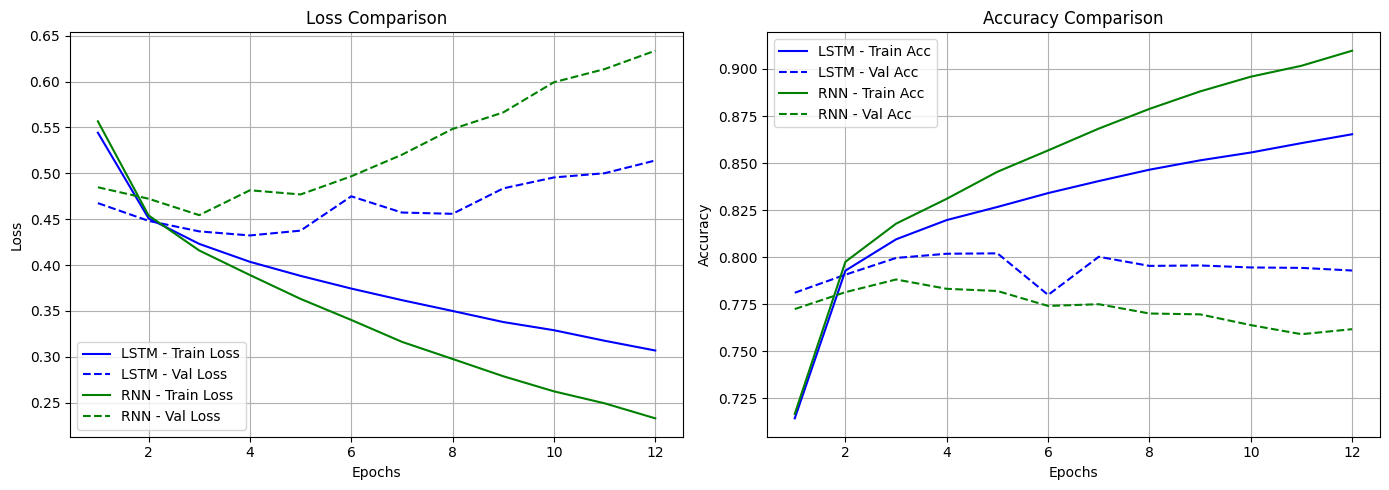

In [42]:
def plot_comparison(history_lstm, history_rnn):
    epochs = range(1, len(history_lstm.history['loss']) + 1)

    # 🔹 Loss usporedba
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_lstm.history['loss'], 'b-', label='LSTM - Train Loss')
    plt.plot(epochs, history_lstm.history['val_loss'], 'b--', label='LSTM - Val Loss')
    plt.plot(epochs, history_rnn.history['loss'], 'g-', label='RNN - Train Loss')
    plt.plot(epochs, history_rnn.history['val_loss'], 'g--', label='RNN - Val Loss')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 🔹 Accuracy usporedba
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_lstm.history['accuracy'], 'b-', label='LSTM - Train Acc')
    plt.plot(epochs, history_lstm.history['val_accuracy'], 'b--', label='LSTM - Val Acc')
    plt.plot(epochs, history_rnn.history['accuracy'], 'g-', label='RNN - Train Acc')
    plt.plot(epochs, history_rnn.history['val_accuracy'], 'g--', label='RNN - Val Acc')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Pozovi funkciju nakon treniranja oba modela:
plot_comparison(history_lstm, history_rnn)


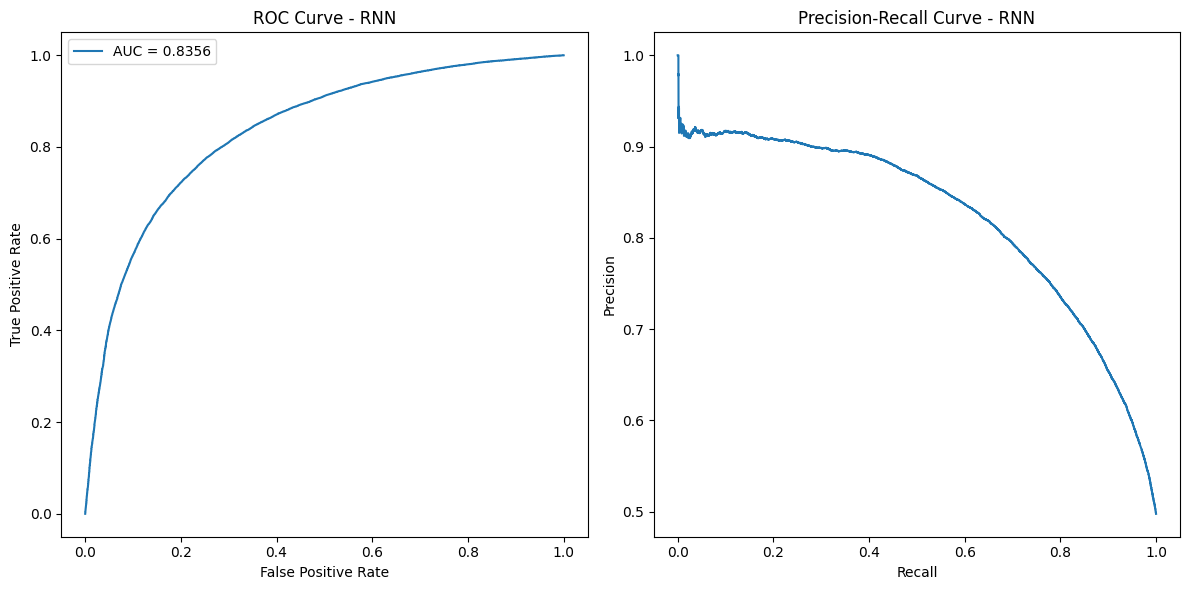

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

# ROC Curve and AUC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_probs)
auc = roc_auc_score(y_test, y_pred_probs)

plt.figure(figsize=(12, 6))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN')
plt.legend()

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_probs)

plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - RNN')

plt.tight_layout()
plt.show()


